## 1. Extracting Tags & Merging into Unique List

### 1.1. General Patterns: Extract tags from general_profiles_data.json

In [6]:
import json

# Load the JSON file
with open('general_profiles_data.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Extract tags, excluding 'N/A' values and usernames
filtered_tags = set()  # [] -> use .extend()
for details in data.values():
    tags = details.get('tags', [])
    filtered_tags.update(tag for tag in tags if tag != "N/A")

# Save tags to a new JSON file
with open('tags_in_general_profiles.json', 'w', encoding='utf-8') as file:
    json.dump(list(filtered_tags), file, indent=4)

print("Tags have been extracted and saved to 'tags_in_general_profiles.json'")

# Count unique tags
unique_tag_count = len(filtered_tags)
print(f"Total unique tags: {unique_tag_count}")

Tags have been extracted and saved to 'tags_in_general_profiles.json'
Total unique tags: 2140


### Community Patterns: Extract tags from profiles_by_comm_data.json

In [7]:
import json

# Load the JSON file
with open('profiles_by_comm_data.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Extract tags, excluding 'N/A' values and usernames
filtered_tags = set()
for comm in data.values():
    for details in comm.values():
        tags = details.get('tags', [])
        filtered_tags.update(tag for tag in tags if tag != "N/A")

# Save tags to a new JSON file
with open('tags_in_members_profiles.json', 'w', encoding='utf-8') as file:
    json.dump(list(filtered_tags), file, indent=4)

print("Tags have been extracted and saved to 'tags_in_members_profiles.json'")

# Count unique tags
unique_tag_count = len(filtered_tags)
print(f"Total unique tags: {unique_tag_count}")

Tags have been extracted and saved to 'tags_in_members_profiles.json'
Total unique tags: 2767


### 1.2. Merging into global list of unique tags

In [10]:
import json

# Load the first tags file
with open('tags_in_general_profiles.json', 'r', encoding='utf-8') as file:
    tags_general = json.load(file)

# Load the second tags file
with open('tags_in_members_profiles.json', 'r', encoding='utf-8') as file:
    tags_members = json.load(file)

# Merge the tags and remove duplicates
all_tags = set(tags_general + tags_members)

# Save the merged tags to a new JSON file
with open('all_tags.json', 'w', encoding='utf-8') as file:
    json.dump(list(all_tags), file, indent=4)

# Count unique tags
unique_tag_count = len(all_tags)
print(f"Total unique tags after merging: {unique_tag_count}")

Total unique tags after merging: 2965


## 2. Word Embeddings & Tag Clustering:

### 2.1. Word2Vec + K-Means

In [1]:
import sys
print(sys.executable)

C:\Users\nastya\thesis\tum-thesis\gensim_env\Scripts\python.exe


In [2]:
!python --version

Python 3.11.6


In [4]:
from gensim.models import Word2Vec
print("Gensim is working!")

Gensim is working!


In [3]:
import json
import re
import numpy as np
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from gensim.downloader import load

# Load tags from JSON file
with open('all_tags.json', 'r', encoding='utf-8') as file:
    tags = json.load(file)

# Preprocess tags (clean special characters, lowercase)
def preprocess_tag(tag):
    tag = re.sub(r'[^a-zA-Z0-9 ]', '', tag)  # Remove special characters
    return tag.lower()

tags = [preprocess_tag(tag) for tag in tags]

# Convert tags into Word2Vec-compatible format (list of lists)
tag_sentences = [[tag] for tag in tags]  # Each tag as a single word sentence

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tag_sentences, vector_size=100, window=5, min_count=1, workers=4)
word_vectors = w2v_model.wv

# Generate tag embeddings
w2v_embeddings = np.array([word_vectors[tag] for tag in tags])

# Apply KMeans clustering
num_clusters = 40  # You can adjust this number
scaler = StandardScaler()
w2v_embeddings_scaled = scaler.fit_transform(w2v_embeddings)
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(w2v_embeddings_scaled)
labels = kmeans.labels_

# Organize clusters
w2v_clusters = defaultdict(list)
for tag, label in zip(tags, labels):
    w2v_clusters[label].append(tag)

# Convert dictionary keys to strings before saving
w2v_clusters_str_keys = {str(k): v for k, v in w2v_clusters.items()}

# Save clusters
with open('word2vec_kmeans_clusters.json', 'w', encoding='utf-8') as file:
    json.dump(w2v_clusters_str_keys, file, indent=4)

print("Word2Vec clustering completed. Clusters saved to 'word2vec_clusters.json'")
print(f"Total Word2Vec clusters: {len(w2v_clusters)}")

for cluster, cluster_tags in w2v_clusters.items():
    print(f"Cluster {cluster}: {cluster_tags}\n")

Word2Vec clustering completed. Clusters saved to 'word2vec_clusters.json'
Total Word2Vec clusters: 40
Cluster 33: ['alexander disease', 'cyclobenzaprine', 'acute leukaemia', 'largactil', 'tuberculosis tb', 'kidney function test', 'celexa', 'buccolam', 'losartan', 'chronic renal failure', 'rifampicin  isoniazid  pyrazinamide', 'androgen deprivation therapy adt', 'eye cancer', 'levoxyl', 'proton therapy', 'chloroquine', 'diverticular disease and diverticulitis', 'metformin  glipizide', 'diarrhoea', 'omentectomy', 'glucose test', 'feeling lonely', 'gold thioglucose', 'sominex', 'primary biliary cholangitis pbc', 'rifampicin  isoniazid', 'diverticulosis', 'rilpivirine', 'avelox', 'edoxaban', 'fleet glycerin suppositories', 'lacosamide', 'sex hormone abnormalities', 'hyoscyamine', 'regaine extra strength', 'amitriptyline', 'diabetes diet', 'cod liver oil', 'diflucan', 'taxotere', 'low sodium diet', 'growth hormone', 'singulair', 'naramig', 'danazol', 'ace inhibitors', 'naturopathy', 'cicles

### 2.2. GloVe + K-Means

In [9]:
import json
import re
import numpy as np
from gensim.models import KeyedVectors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from gensim.downloader import load

# Load tags from JSON file
with open('all_tags.json', 'r', encoding='utf-8') as file:
    tags = json.load(file)

# Preprocess tags (clean special characters, lowercase)
def preprocess_tag(tag):
    tag = re.sub(r'[^a-zA-Z0-9 ]', '', tag)  # Remove special characters
    return tag.lower()

tags = [preprocess_tag(tag) for tag in tags]

# Load pre-trained GloVe model
glove_model = load("glove-wiki-gigaword-100")  # 100-dimensional GloVe vectors

# Generate GloVe embeddings
glove_embeddings = []
valid_tags = []
for tag in tags:
    if tag in glove_model:
        glove_embeddings.append(glove_model[tag])
        valid_tags.append(tag)  # Keep only tags that exist in GloVe

glove_embeddings = np.array(glove_embeddings)

# Apply KMeans clustering to GloVe embeddings
num_clusters = 20  # You can adjust this number
scaler = StandardScaler()
glove_embeddings_scaled = scaler.fit_transform(glove_embeddings)
kmeans_glove = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans_glove.fit(glove_embeddings_scaled)
glove_labels = kmeans_glove.labels_

# Organize clusters
glove_clusters = defaultdict(list)
for tag, label in zip(valid_tags, glove_labels):
    glove_clusters[label].append(tag)

# Convert dictionary keys to strings before saving
glove_clusters_str_keys = {str(k): v for k, v in glove_clusters.items()}

# Save clusters
with open('glove_clusters.json', 'w', encoding='utf-8') as file:
    json.dump(glove_clusters_str_keys, file, indent=4)

print("GloVe clustering completed. Clusters saved to 'glove_clusters.json'")
print("GloVe Clusters:")
for cluster, cluster_tags in glove_clusters.items():
    print(f"Cluster {cluster}: {cluster_tags}\n")

GloVe clustering completed. Clusters saved to 'glove_clusters.json'
GloVe Clusters:
Cluster 3: ['lactase', 'saline', 'progesterone', 'melatonin', 'seizure', 'dopamine', 'tryptophan', 'noradrenaline', 'immunoglobulin', 'inositol', 'taurine', 'testosterone', 'oestrogen', 'isoflavones', 'lycopene', 'estradiol', 'carnitine', 'insulin', 'methamphetamine', 'garlic', 'lysine', 'tyrosine', 'adenosine', 'collagen', 'creatine', 'kelp', 'kaolin', 'glutamine', 'cysteine', 'dextrose', 'ginseng', 'ephedrine', 'haemoglobin', 'niacin', 'mannitol', 'heparin', 'lecithin', 'glutathione', 'nicotinamide', 'adrenaline', 'steroids', 'biotin']

Cluster 0: ['diclofenac', 'antacids', 'haldol', 'laxatives', 'valerian', 'isotretinoin', 'azithromycin', 'fluoxetine', 'doxycycline', 'lovastatin', 'streptomycin', 'sertraline', 'metformin', 'coumadin', 'ativan', 'lorazepam', 'provera', 'finasteride', 'hydroquinone', 'naltrexone', 'temazepam', 'ivermectin', 'ketamine', 'ciprofloxacin', 'castration', 'atorvastatin', 'qu

### FastText + HDBSCAN

In [1]:
import json
import re
import numpy as np
from gensim.models import KeyedVectors
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import hdbscan
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.downloader import load
import pandas as pd

# Step 1: Load existing tags (adjust path if needed)
with open('all_tags.json', 'r', encoding='utf-8') as file:
    tags = json.load(file)

# Flatten all tags
# all_tags = []
# for tags in clusters.values():
#     all_tags.extend(tags)

# Step 2: Preprocess tags
def preprocess_tag(tag):
    tag = re.sub(r'[^a-zA-Z0-9 ]', '', tag)  # Remove special characters
    return tag.lower()

all_tags = [preprocess_tag(tag) for tag in tags]

# # Step 3: Load pre-trained FastText vectors (this may take some time to download first time)
# print("Loading FastText model...")
# fasttext_model = load('fasttext-wiki-news-subwords-300')

# # Step 4: Generate embeddings
# embeddings = []
# for tag in all_tags:
#     words = tag.split()
#     word_vectors = []
#     for word in words:
#         if word in fasttext_model:
#             word_vectors.append(fasttext_model[word])
#     if word_vectors:
#         avg_vector = np.mean(word_vectors, axis=0)
#         embeddings.append(avg_vector)
#     else:
#         embeddings.append(np.zeros(300))  # Unknown words fallback

# embeddings = np.array(embeddings)

# # Step 5: Standardize
# scaler = StandardScaler()
# embeddings_scaled = scaler.fit_transform(embeddings)

# # Step 6: HDBSCAN clustering
# print("Running HDBSCAN clustering...")
# clusterer = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean')
# cluster_labels = clusterer.fit_predict(embeddings_scaled)

# # Step 7: Organize clusters
# hdbscan_clusters = defaultdict(list)
# for tag, label in zip(all_tags, cluster_labels):
#     if label != -1:  # Exclude noise points
#         hdbscan_clusters[label].append(tag)

# # Step 8: Print cluster summary
# print(f"Total clusters found (excluding noise): {len(hdbscan_clusters)}")
# for label, tags in hdbscan_clusters.items():
#     print(f"\nCluster {label} ({len(tags)} tags):")
#     print(tags[:10])  # Show first 10 tags per cluster

# # Step 9: Visualization with t-SNE
# print("Visualizing clusters...")
# tsne = TSNE(n_components=2, random_state=42, perplexity=30)
# tsne_result = tsne.fit_transform(embeddings_scaled)

# plt.figure(figsize=(12, 8))
# scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=[label if label != -1 else 99 for label in cluster_labels], cmap='tab20', alpha=0.7)
# plt.title('HDBSCAN Clustering of Health Tags (FastText Embeddings)')
# plt.xlabel('t-SNE Dim 1')
# plt.ylabel('t-SNE Dim 2')
# plt.colorbar(scatter, label='Cluster Label (-1 = Noise)')
# plt.show()


In [4]:
# Step 3: Load pre-trained FastText vectors (this may take some time to download first time)
print("Loading FastText model...")
fasttext_model = load('fasttext-wiki-news-subwords-300')

Loading FastText model...


Running HDBSCAN clustering...


C:\Users\nastya\thesis\tum-thesis\gensim_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\nastya\thesis\tum-thesis\gensim_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Total clusters found (excluding noise): 16

Cluster 14 (829 tags):
['azilect', 'pancrelipase', 'zepatier', 'rivotril', 'haldol', 'calquence', 'librium', 'audavate', 'budenofalk', 'ofev']

Cluster 0 (7 tags):
['vaniqa cream', 'epaderm cream', 'efudix cream', 'e45 cream', 'dermol cream', 'calmurid cream', 'fucidin cream']

Cluster 8 (14 tags):
['wolffparkinsonwhite syndrome wpw', 'sjogrens syndrome', 'guillainbarre syndrome', 'cushings syndrome', 'cogans syndrome', 'noonan syndrome', 'beckwithwiedemann syndrome', 'nephrotic syndrome', 'brugada syndrome', 'gilberts syndrome']

Cluster 15 (23 tags):
['prochlorperazine', 'triamterene  hydrochlorothiazide', 'hydroxyzine', 'lisinopril  hydrochlorothiazide', 'trihexyphenidyl', 'amitriptyline  perphenazine', 'fludarabine cyclophosphamide and rituximab fcr', 'valsartan  hydrochlorothiazide', 'procarbazine', 'telmisartan  amlodipine']

Cluster 13 (38 tags):
['functional neurological disorder fnd', 'cerebral autosomal dominant arteriopathy with su

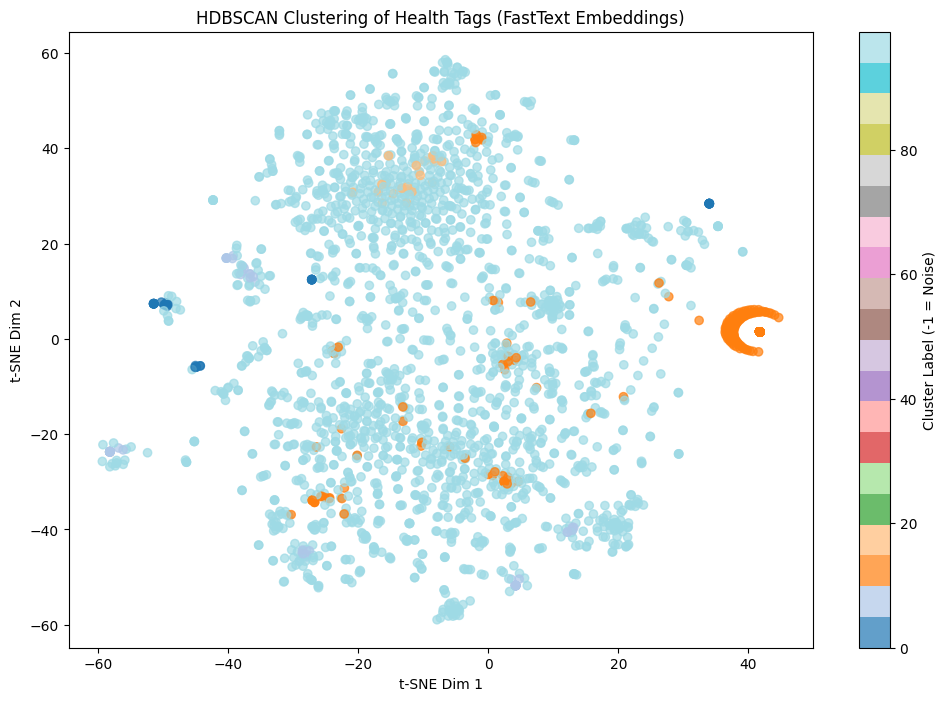

In [8]:
# import umap

# Step 4: Generate embeddings
embeddings = []
for tag in all_tags:
    words = tag.split()
    word_vectors = []
    for word in words:
        if word in fasttext_model:
            word_vectors.append(fasttext_model[word])
    if word_vectors:
        avg_vector = np.mean(word_vectors, axis=0)
        embeddings.append(avg_vector)
    else:
        embeddings.append(np.zeros(300))  # Unknown words fallback

embeddings = np.array(embeddings)

# Step 5: Standardize
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# # Apply UMAP dimensionality reduction
# print("Running UMAP reduction...")
# reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
# embeddings_umap = reducer.fit_transform(embeddings_scaled)

# Step 6: HDBSCAN clustering
print("Running HDBSCAN clustering...")
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')  # 5-15 min_cluster
cluster_labels = clusterer.fit_predict(embeddings_scaled)

# Step 7: Organize clusters
hdbscan_clusters = defaultdict(list)
for tag, label in zip(all_tags, cluster_labels):
    if label != -1:  # Exclude noise points
        hdbscan_clusters[label].append(tag)

# Step 8: Print cluster summary
print(f"Total clusters found (excluding noise): {len(hdbscan_clusters)}")
for label, tags in hdbscan_clusters.items():
    print(f"\nCluster {label} ({len(tags)} tags):")
    print(tags[:10])  # Show first 10 tags per cluster

# Step 9: Visualization with t-SNE
print("Visualizing clusters...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(embeddings_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=[label if label != -1 else 99 for label in cluster_labels], cmap='tab20', alpha=0.7)
plt.title('HDBSCAN Clustering of Health Tags (FastText Embeddings)')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.colorbar(scatter, label='Cluster Label (-1 = Noise)')
plt.show()

### Sentence Transformer (BERT) + K-Means

In [1]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
# import umap
import hdbscan
import numpy as np
import json

# Load tags
with open('all_tags.json', 'r', encoding='utf-8') as file:
    tags = json.load(file)

# Initialize transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
embeddings = model.encode(tags)

# # Optional: UMAP reduction
# umap_embeddings = umap.UMAP(n_neighbors=15, n_components=10, metric='cosine').fit_transform(embeddings)

# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
labels = clusterer.fit_predict(embeddings)

# Print results
print(set(labels), "Clusters found")

# Optional: Save clusters
clusters = {}
for tag, label in zip(tags, labels):
    clusters.setdefault(str(label), []).append(tag)

with open('bert_kmeans_clusters.json', 'w', encoding='utf-8') as file:
    json.dump(clusters, file, indent=4)


C:\Users\nastya\thesis\tum-thesis\gensim_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\nastya\thesis\tum-thesis\gensim_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


{0, 1, 2, -1} Clusters found


### Sentence Transformer (BERT) + HDBSCAN (no fix k)

C:\Users\nastya\thesis\tum-thesis\gensim_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\nastya\thesis\tum-thesis\gensim_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\nastya\thesis\tum-thesis\gensim_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Total clusters found (excluding noise): 112


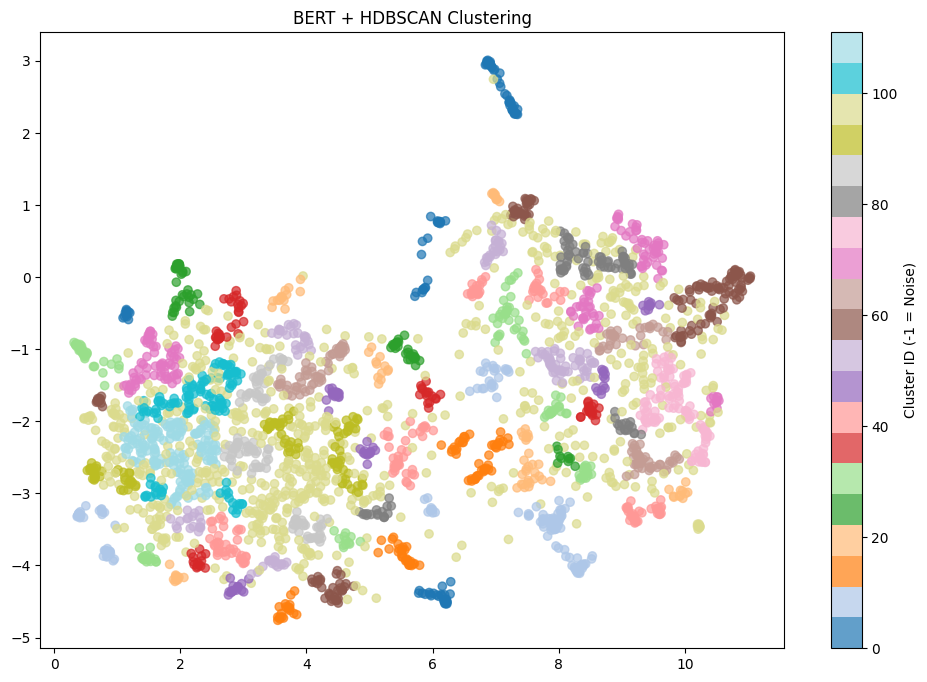

In [1]:
from sentence_transformers import SentenceTransformer
import hdbscan
from sklearn.preprocessing import StandardScaler
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import umap

# Step 1: Load tags
with open('all_tags.json', 'r', encoding='utf-8') as file:
    tags = json.load(file)

# Step 2: Convert tags to BERT embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight, good for clustering
embeddings = model.encode(tags)

# Optional: Scale embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Step 3: Dimensionality reduction (optional but improves clustering)
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
embeddings_umap = umap_reducer.fit_transform(embeddings_scaled)

# Step 4: HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=3, metric='euclidean')
labels = clusterer.fit_predict(embeddings_umap)

# Step 5: Organize clusters
clusters = defaultdict(list)
for tag, label in zip(tags, labels):
    if label != -1:  # Ignore noise points
        clusters[str(label)].append(tag)

# Save clusters
with open('bert_hdbscan_clusters.json', 'w', encoding='utf-8') as file:
    json.dump(clusters, file, indent=4)

print(f"Total clusters found (excluding noise): {len(clusters)}")

# Optional: Visualization
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], c=[label if label != -1 else 99 for label in labels], cmap='tab20', alpha=0.7)
plt.title('BERT + HDBSCAN Clustering')
plt.colorbar(label='Cluster ID (-1 = Noise)')
plt.show()


### BioBERT + Aglomerative Clustering

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
from tqdm import tqdm
import json

# 1. Load your tags
with open('all_tags.json', 'r') as file:
    tags = json.load(file)

tags = list(set([tag.lower() for tag in tags]))  # Lowercase + deduplicate

# 2. Load BioBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

# 3. Embed tags
def embed_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=64)
    with torch.no_grad():
        outputs = model(**inputs)
    # Use CLS token embedding
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

embeddings = []
for tag in tqdm(tags):
    embeddings.append(embed_text(tag))

100%|██████████████████████████████████████████████████████████████████████████████| 2964/2964 [06:08<00:00,  8.05it/s]


In [7]:
# 4. Agglomerative Clustering
n_clusters = 40  # You can tune this
clustering = AgglomerativeClustering(n_clusters=n_clusters)
labels = clustering.fit_predict(embeddings)

# 5. Save results
df = pd.DataFrame({'Tag': tags, 'Cluster': labels})
df.sort_values(by='Cluster', inplace=True)

cluster_dict = {}
for cluster_label in sorted(df['Cluster'].unique()):
    cluster_dict[f'Cluster_{cluster_label}'] = df[df['Cluster'] == cluster_label]['Tag'].tolist()
    
with open('bioBERT_clusters.json', 'w') as f:
    json.dump(cluster_dict, f, indent=4)

## ChatGPT

### 1."can you manually cluster the tags?" (input: all_tags.json; outout: chatgpt_clusters.json) # clsuters = 16

There are **16 clusters** in total.
1. **Heart & Cardiovascular Problems**
2. **Diabetes & Metabolic Disorders**
3. **Mental Health & Neurological Conditions**
4. **Women’s Health**
5. **Cancer-Related**
6. **Lifestyle-Related (Smoking, Diet, Fitness)**
7. **Autoimmune & Inflammatory Diseases**
8. **Respiratory Conditions**
9. **Infectious Diseases**
10. **Digestive System Disorders**
11. **Musculoskeletal Disorders**
12. **Kidney & Urinary System**
13. **Eye & Ear Conditions**
14. **Skin Conditions**
15. **Surgical Procedures & Treatments**
16. **General Medications & Supplements**
17. **Other** (for tags that didn’t fit clearly into above categories)